In [38]:
from sklearn import preprocessing
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder

In [39]:
heart = pd.read_csv('datasets/heart.csv')
heart = heart[['sex', 'age', 'thalachh', 'trtbps', 'chol', 'cp', 'fbs', 'restecg', 'exng', 'oldpeak', 'slp', 'caa', 'thall', 'output']]

In [40]:
X = heart.iloc[:,1:5]
y = heart['sex']
names = heart.columns[1:5] 
feature_names = heart.columns[0]
targets = np.unique(y)

In [41]:
class Model(nn.Module):
    def __init__(self, input_features=4, hidden_layer1=25, hidden_layer2=30, output_features=3):
        super().__init__()
        self.input = nn.Linear(input_features, hidden_layer1)
        self.hidden = nn.Linear(hidden_layer1, hidden_layer2)
        self.output = nn.Linear(hidden_layer2, output_features)
    def forward(self, x):
        x = F.relu(self.input(x))
        x = F.relu(self.hidden(x))
        x = F.softmax(self.output(x), dim=1)
        return x

In [42]:
# Scale data to have 0 means and variance 1, it helps convergence
scaler = preprocessing.StandardScaler() #lo scaler normalizza i dati, questo aiuta nell'apprendimento del modello
X_scaled = scaler.fit_transform(X)
# Split the data set into training and testing
test_size = 0.2
indices = np.random.permutation(len(heart)) # shuffle records / species
n_test_samples = int(test_size * len(heart))
X_train = X_scaled[indices[:-n_test_samples]]
y_train = y[indices[:-n_test_samples]]
X_test = X_scaled[indices[-n_test_samples:]]
y_test = y[indices[-n_test_samples:]]
# no string tensor in pytorch. Strings to index
le = preprocessing.LabelEncoder()
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(le.fit_transform(y_train))
y_test = torch.LongTensor(le.fit_transform(y_test))

In [43]:
model = Model()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
epochs = 100
losses = []
for i in range(epochs):
    y_pred = model.forward(X_train) # foreward step
    loss = loss_fn(y_pred, y_train) # compute loss with current weights
    losses.append(loss.item())
    print(f'epoch: {i:2} loss: {loss.item():10.8f}')
    optimizer.zero_grad() # initialize gradients of optimized tensors to 0
    loss.backward() # compute new gradient (backward step)
    optimizer.step()

epoch:  0 loss: 1.12192452
epoch:  1 loss: 1.09938109
epoch:  2 loss: 1.07487309
epoch:  3 loss: 1.04783511
epoch:  4 loss: 1.01893210
epoch:  5 loss: 0.98916715
epoch:  6 loss: 0.96001476
epoch:  7 loss: 0.93326312
epoch:  8 loss: 0.91066837
epoch:  9 loss: 0.89337736
epoch: 10 loss: 0.88141733
epoch: 11 loss: 0.87373722
epoch: 12 loss: 0.86907607
epoch: 13 loss: 0.86627752
epoch: 14 loss: 0.86443031
epoch: 15 loss: 0.86285669
epoch: 16 loss: 0.86105937
epoch: 17 loss: 0.85853553
epoch: 18 loss: 0.85472834
epoch: 19 loss: 0.84960973
epoch: 20 loss: 0.84419394
epoch: 21 loss: 0.83940226
epoch: 22 loss: 0.83605486
epoch: 23 loss: 0.83445233
epoch: 24 loss: 0.83418661
epoch: 25 loss: 0.83477497
epoch: 26 loss: 0.83549571
epoch: 27 loss: 0.83577645
epoch: 28 loss: 0.83541411
epoch: 29 loss: 0.83441526
epoch: 30 loss: 0.83295047
epoch: 31 loss: 0.83130205
epoch: 32 loss: 0.82970005
epoch: 33 loss: 0.82832015
epoch: 34 loss: 0.82732356
epoch: 35 loss: 0.82684422
epoch: 36 loss: 0.82673478
e

Text(0.5, 1.0, 'Losses')

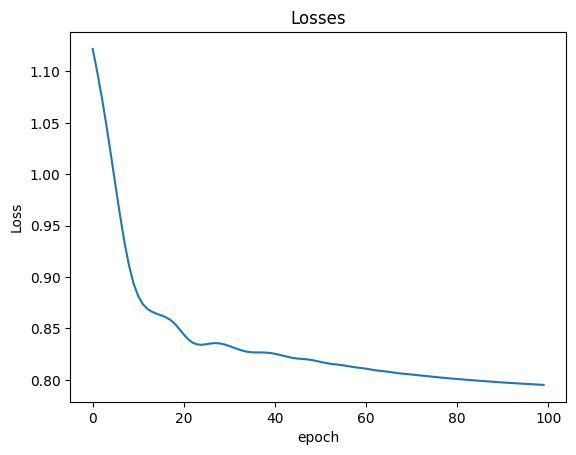

In [44]:
la = np.array(losses)
plt.figure()
plt.plot(range(epochs), la)
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.title("Losses")

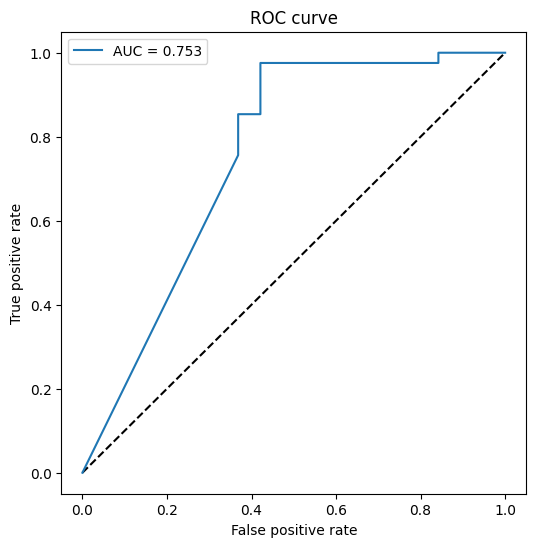

In [45]:
enc = OneHotEncoder()
Y_onehot = enc.fit_transform(y_test[:, np.newaxis]).toarray()

with torch.no_grad():
    y_pred = model(X_test).numpy()
    fpr, tpr, threshold = roc_curve(Y_onehot[:, 1], y_pred[:, 1])

roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(roc_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend()
plt.show()